# SI

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import seaborn as sns
from matplotlib import style
import warnings

from PIL import Image, ImageFont, ImageDraw 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os
import cv2

### Global Settings

In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")
style.use("ggplot")
pathImage = "./data/" # data contiene todas las fotos. Esta en la misma carpeta de este proyecto
SEED = 42
TEST_SIZE = 0.2

## Entendimiento

In [3]:
df = pd.read_csv("./dataset.csv") #dataset esta en la misma carpeta que este jupiter
df

patientid  \
0                                         3   
1                                         3   
2                                         3   
3                                         7   
4                                         7   
...                                     ...   
15270  2c917d3a-95cb-4c11-802c-f83e28cb37bc   
15271  3040d9d7-d895-453f-887c-616c10531960   
15272  c07f52df-d481-434f-84c1-04263926ac40   
15273  c109061a-d815-4cae-8343-9230d8024adf   
15274  c18d1138-ba74-4af5-af21-bdd4d2c96bb5   

                                                filename      label dataset  
0      SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....  pneumonia   cohen  
1      SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....  pneumonia   cohen  
2      SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...  pneumonia   cohen  
3      SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...  pneumonia   cohen  
4      SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...  pneumonia   cohen  
...                                                  ...        ...     ...  
15270           2c917d3a-95cb-4c11-802c-f83e28cb37bc.png  pneumonia    rsna  
15271           3040d9d7-d895-453f-887c-616c10531960.png  pneumonia    rsna  
15272           c07f52df-d481-434f-84c1-04263926ac40.png  pneumonia    rsna  
15273           c109061a-d815-4cae-8343-9230d8024adf.png  pneumonia    rsna  
15274           c18d1138-ba74-4af5-af21-bdd4d2c96bb5.png  pneumonia    rsna  

[15275 rows x 4 columns]

<AxesSubplot:xlabel='label', ylabel='count'>

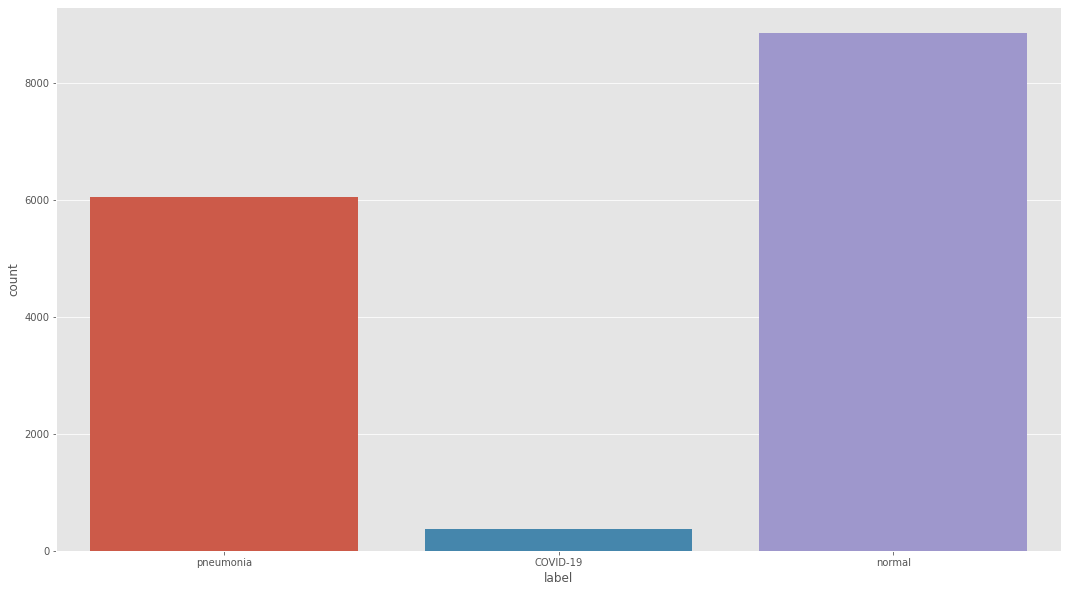

In [4]:
plt.figure(figsize=(18,10))
sns.countplot(df.label)

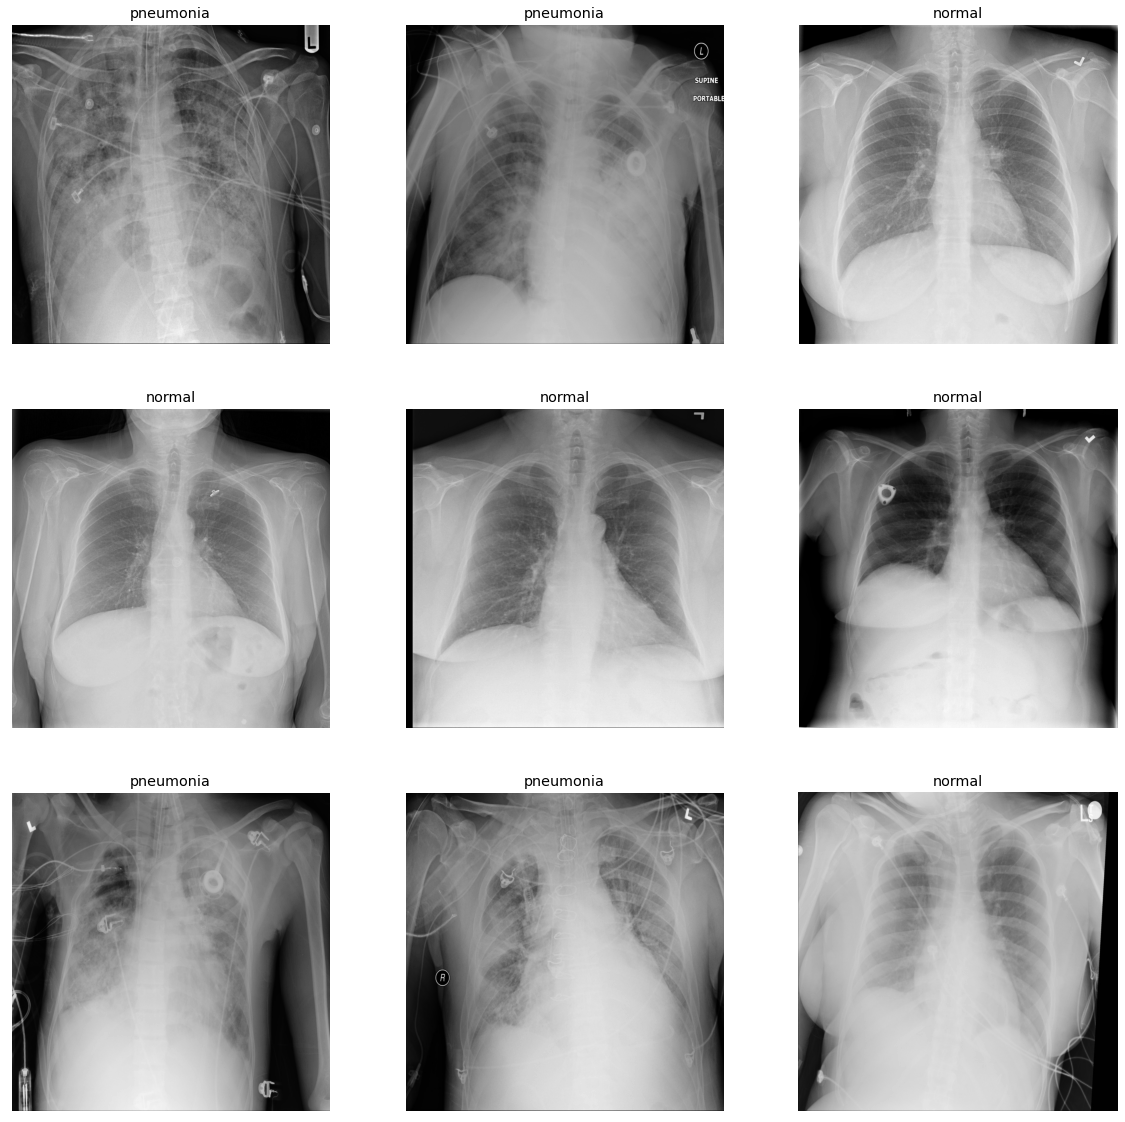

In [5]:
sample = df.sample(9)
fig, axs = plt.subplots(3,3,figsize=(20,20))
plt.axis('off')
i = 0
for ax in axs.flat:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    label = sample.label.values[i]
    path = pathImage + sample.filename.values[i]
    
    img = cv2.imread(path, 0) 
    ax.imshow(img, cmap='gray')
    ax.set_title(label)
    i+=1

### Preprocesamiento de datos

In [6]:
df.shape

(15275, 4)

#### Logica de desarrollo:
En Keras, cuando hacemos fit. entrenamos con nuevos datos. Podemos llamar varias veces al metodo **fit** y seguir entrenando el modelo como si le estuvieramos pasando de una sola vez todos los datos.

Entonces para que esto funcione debemos hacer varios baches de carga de datos, dividirlo en train y test y luego enviarlo a nuestro modelo para entranarlo.

In [7]:
def get_batch_data(df, START = 0, BATCH_SIZE = 1500):
    
    Data = []
    Target = []
    resize = 224

    for index, row in tqdm(df[START:].iterrows()):
        label = row['label']
        path = pathImage + row['filename']
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ### NORMALIZING DATA
        image = cv2.resize(image, (resize, resize)) /255

        Data.append(image)
        Target.append(label)
                          
        if index == (BATCH_SIZE-1):
            break
    
    print("Cantidad de datos cargados: {0}".format(len(Data)))
        
    ### ENCOFING LABELS
    le = LabelEncoder()
    labels = le.fit_transform(Target)
    labels = to_categorical(labels)

    print("Clases ",le.classes_)
    
    return train_test_split(Data, labels,test_size=TEST_SIZE, stratify=labels, random_state=SEED)

In [8]:
(x_train, x_test, y_train, y_test) = get_batch_data(df)

1499it [00:25, 57.73it/s]

Cantidad de datos cargados: 1500
Clases  ['COVID-19' 'normal' 'pneumonia']


In [10]:
len(x_train),len(x_test),len(y_train),len(y_test)

(1200, 300, 1200, 300)

In [14]:
x_train[0].shape

(224, 224, 3)

### Desarrollando el modelo

In [94]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
######### NO CORRER EJEMPLO DE COMO FUNCIONARIA

ITERACIONES = df.shape[0] // BATCH_SIZE 
START = 0
HISTORY = []

for i in range(ITERACIONES)
    (x_train, x_test, y_train, y_test) = get_batch_data(df,START,BATCH_SIZE)
    START = START + len(x_train) + len(x_test)
    HISTORY[i] = model.fit( 
        ...params, # OPTIMIZER, METRICS, ETC.
        data=(x_train,y_train), 
        validate_data=(x_test,y_test))

######################

In [65]:
# https://keras.io/api/applications/inceptionresnetv2/
engine = keras.applications.InceptionResNetV2(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224,224,3),
    classifier_activation = 'sigmoid')

219062272/219055592 [==============================] - 57s 0us/step
